# DAL Assignment 8

## Utkarsh Pathak DA24S011


#### The main idea behind AdaBoost is to iteratively train the weak classifier on the training dataset with each successive classifier giving more weightage to the data points that are misclassified. The final AdaBoost model is decided by combining all the weak classifier that has been used for training with the weightage given to the models according to their accuracies. The weak model which has the highest accuracy is given the highest weightage while the model which has the lowest accuracy is given a lower weightage.

## Task 1 :  Let's implement the Adaboost algorithm from scratch on a non-linear dataset, the circles dataset.

## Let us follow the AdaBoost Algorithm fom wikipedia's Discrete Adaboost:

1. **Samples**  
   $ x_1, \dots, x_n $

2. **Desired outputs**  
   $ y_1, \dots, y_n, \quad y \in \{-1, 1\} $

3. **Initial weights**  
   $ w_{1,1}, \dots, w_{n,1} $ set to $ \frac{1}{n} $

4. **Error function**  
   $ E(f(x), y_i) = e^{-y_i f(x_i)} $

5. **Weak learners**  
   $ h: x \rightarrow \{-1, 1\} $

6. **For $ t $ in $ 1 \dots T $**:

   1. **Choose $ h_t(x) $**:  
      Find weak learner $ h_t(x) $ that minimizes $ \epsilon_t $, the weighted sum error for misclassified points:  
      $ \epsilon_t = \sum_{h_t(x_i) \neq y_i}^{n} w_{i,t} $

   2. **Choose**  
      $ \alpha_t = \frac{1}{2} \ln \left( \frac{1 - \epsilon_t}{\epsilon_t} \right) $

   3. **Add to ensemble**:  
      $ F_t(x) = F_{t-1}(x) + \alpha_t h_t(x) $

   4. **Update weights**:  
      $ w_{i,t+1} = w_{i,t} e^{-y_i \alpha_t h_t(x_i)} \quad \text{for } i \in 1 \dots n $

   5. **Renormalize** $ w_{i,t+1} $ such that  
      $ \sum_{i} w_{i,t+1} = 1 $

   **Note**: It can be shown that  
   $ \frac{\sum_{h_t(x_i) = y_i} w_{i,t+1}}{\sum_{h_t(x_i) \neq y_i} w_{i,t+1}} = \frac{\sum_{h_t(x_i) = y_i} w_{i,t}}{\sum_{h_t(x_i) \neq y_i} w_{i,t}} $  
   at every step, which can simplify the calculation of the new weights.


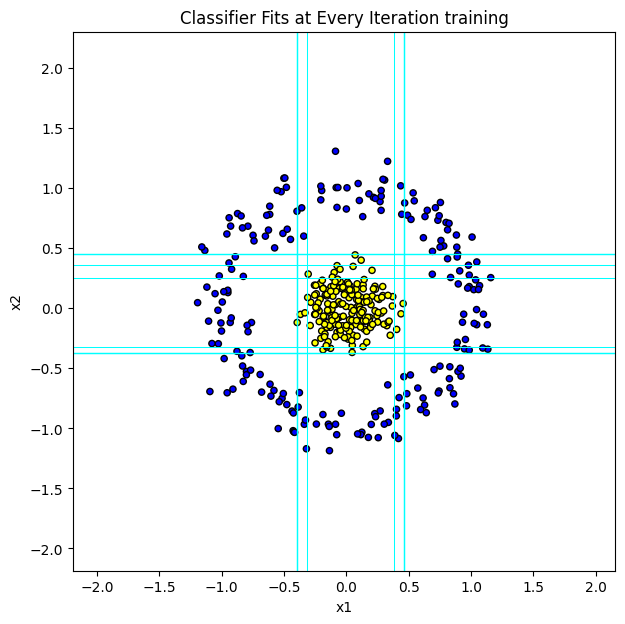

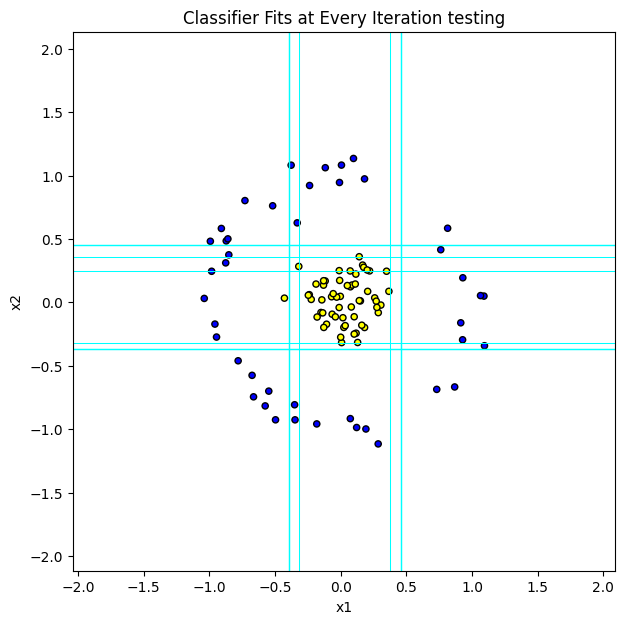

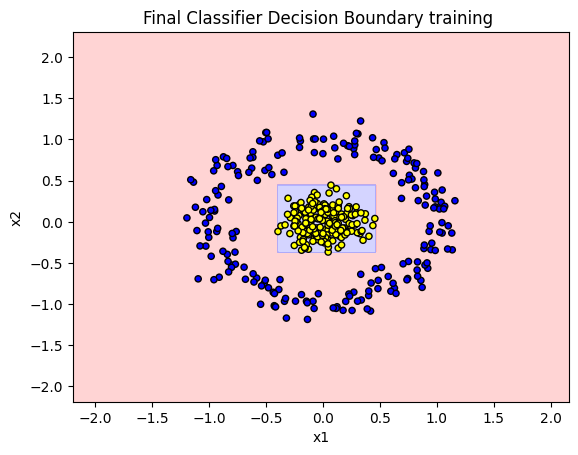

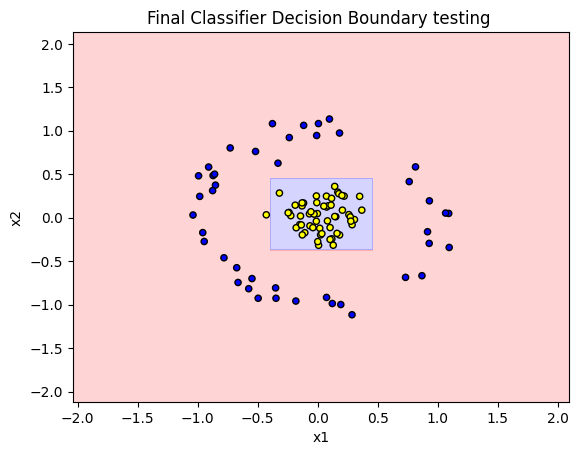

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from matplotlib import colors

# This dataset consists of points that form two concentric circles.
# The 'factor' parameter controls the distance between the circles.
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)

# Change labels from {0, 1} to {-1, 1} for AdaBoost compatibility
y = np.where(y == 0, -1, 1)

# Split the dataset into training and testing sets.
# 80% of the data will be used for training, and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#AdaBoost from scratch
class AdaBoost:
    def __init__(self, n_clf=100, eta=0.5):
        """
        Initialize the AdaBoost algorithm.

        Parameters:
        n_clf (int): Number of weak classifiers (decision trees).
        eta (float): Learning rate that influences classifier weights.
        """
        self.n_clf = n_clf  # Number of weak classifiers
        self.eta = eta  # Learning rate

    def fit(self, X, y):
        """
        Fit the AdaBoost model to the training data.

        Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).
        y (ndarray): Target vector of shape (n_samples,).
        """
        n_samples, n_features = X.shape

        # Initialize weights: each sample starts with equal weight
        w = np.ones(n_samples) / n_samples

        # Lists to store the weak classifiers and their weights
        self.clfs = []
        self.alpha = []
        self.all_preds = []  # To store predictions for each iteration

        # Iterate for the specified number of weak classifiers
        for _ in range(self.n_clf):
            # Train a weak classifier (decision stump)
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(X, y, sample_weight=w)  # Fit with the current weights

            # Predict using the weak classifier
            pred = clf.predict(X)
            self.all_preds.append(pred)  # Save predictions at each step

            # Calculate the weighted error of the classifier
            error = np.sum(w * (pred != y)) / np.sum(w)

            # Compute the weight of the weak classifier
            # Avoid division by zero with a small constant (1e-10)
            clf_weight = self.eta * np.log((1 - error) / (error + 1e-10))

            # Store the classifier and its weight
            self.clfs.append(clf)
            self.alpha.append(clf_weight)

            # Update weights for the next iteration
            # Weight update formula: w_i * exp(-y_i * alpha_t * h_t(x_i))
            w = w * np.exp(-clf_weight * y * pred)
            w /= np.sum(w)  # Normalize weights to sum to 1

    def predict(self, X):
        """
        Predict the class labels for the provided data.

        Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).

        Returns:
        ndarray: Predicted class labels.
        """
        # Combine predictions from all weak classifiers, weighted by their alpha
        clf_preds = np.array([alpha * clf.predict(X) for clf, alpha in zip(self.clfs, self.alpha)])

        # Final prediction is the sign of the weighted sum
        y_pred = np.sign(np.sum(clf_preds, axis=0))
        return y_pred

    def plot_overlaid_iterations(self, X, y, dataset_type="training"):
        """
        Plot the decision boundaries of weak classifiers at each iteration.

        Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).
        y (ndarray): Target vector of shape (n_samples,).
        """
        plt.figure(figsize=(7, 7))
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

        # Plot decision boundaries for each weak classifier
        for i, clf in enumerate(self.clfs):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # Predict on the grid
            Z = Z.reshape(xx.shape)
            # Plot contour for the classifier decision boundary
            plt.contour(xx, yy, Z, alpha=1, cmap='cool', levels=[0], linestyles=['-'], linewidths=0.75)

        # Plot data points, coloring them based on true labels
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'yellow']), edgecolor='k', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"Classifier Fits at Every Iteration {dataset_type}")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.show()

    def plot_final_classifier(self, X, y,dataset_type="training"):
        """
        Plot the final ensemble classifier's decision boundary.

        Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).
        y (ndarray): Target vector of shape (n_samples,).
        """
        self.plot_decision_boundary(X, y, final=True)
        plt.title(f"Final Classifier Decision Boundary {dataset_type} ")
        plt.show()

    def plot_decision_boundary(self, X, y, final=False):
        """
        Plot the decision boundary of the classifier.

        Parameters:
        X (ndarray): Feature matrix of shape (n_samples, n_features).
        y (ndarray): Target vector of shape (n_samples,).
        final (bool): Flag to indicate if this is the final classifier plot.
        """
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

        # If plotting the final decision boundary, use the ensemble prediction
        if final:
            Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = self.clfs[-1].predict(np.c_[xx.ravel(), yy.ravel()])  # For intermediate steps

        Z = Z.reshape(xx.shape)

        # Contour plot of the decision boundary
        plt.contourf(xx, yy, Z, alpha=0.5, cmap=colors.ListedColormap(['#FFAAAA', '#AAAAFF']))

        # Scatter plot of the data points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'yellow']), edgecolor='k', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel('x1')
        plt.ylabel('x2')

#Train Adaboost model
adaboost = AdaBoost(n_clf=100, eta=0.5)  # Create AdaBoost instance
adaboost.fit(X_train, y_train)  # Fit model to training data

#Plot classifier fits at every iteration for both Traing and Test data to validate the generalisability of the data
adaboost.plot_overlaid_iterations(X_train, y_train)
adaboost.plot_overlaid_iterations(X_test, y_test, dataset_type="testing")

#Plot final ensembled classifier decision boundary for both Traing and Test data to validate the generalisability of the data
adaboost.plot_final_classifier(X_train, y_train)
adaboost.plot_final_classifier(X_test, y_test, dataset_type="testing")


# Task 2 : Let's run Adaboost implementation with several weak classifiers such as LogReg, DecisionStump, DecisionTree(depth=3), Linear SVM, and LDA

### Let us create some reusable classes and methods

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from matplotlib import colors

#Generate the circles dataset
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y = np.where(y == 0, -1, 1)  # Change labels from {0, 1} to {-1, 1} for Adaboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Adaboost from scratch
class AdaBoost:
    def __init__(self, n_clf=50, eta=0.5, base_clf=None):
        self.n_clf = n_clf  # Number of weak classifiers
        self.eta = eta  # Learning rate
        self.base_clf = base_clf  # Base classifier to be used

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize weights
        w = np.ones(n_samples) / n_samples
        self.clfs = []
        self.alpha = []
        self.all_preds = []  # To store predictions for each iteration

        # Define which classifiers support sample weights as LDA doesn't have that attribute
        supports_sample_weight = ['DecisionTreeClassifier', 'LogisticRegression', 'SVC']

        for _ in range(self.n_clf):
            # Train weak classifier
            clf = clone(self.base_clf)
            clf_name = clf.__class__.__name__

            # Check if the classifier supports `sample_weight`
            if clf_name in supports_sample_weight:
                clf.fit(X, y, sample_weight=w)
            else:
                clf.fit(X, y)

            # Predict
            pred = clf.predict(X)
            self.all_preds.append(pred)  # Save predictions at each step
            # Error calculation
            error = np.sum(w * (pred != y)) / np.sum(w)
            # Classifier weight
            clf_weight = self.eta * np.log((1 - error) / (error + 1e-10))
            self.clfs.append(clf)
            self.alpha.append(clf_weight)

            # Update weights
            w = w * np.exp(-clf_weight * y * pred)
            w /= np.sum(w)  # Normalize to keep it a probability distribution

    def predict(self, X):
        #Strong classifier is the weighted sum of weak classifiers
        clf_preds = np.array([alpha * clf.predict(X) for clf, alpha in zip(self.clfs, self.alpha)])
        y_pred = np.sign(np.sum(clf_preds, axis=0))
        return y_pred

        # Implementing get_params for compatibility with GridSearchCV which uses the inbuilt adaboost method
    def get_params(self, deep=True):
        return {
            'base_clf': self.base_clf,
            'n_clf': self.n_clf,
            'eta': self.eta
        }

    # Implementing set_params for compatibility with GridSearchCV
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def plot_overlaid_iterations(self, X, y, dataset_type="training"):
        # Plotting classifier fit at every iteration
        plt.figure(figsize=(7, 7))
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

        # Plot decision boundaries for each iteration
        for i, clf in enumerate(self.clfs):
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, alpha=(i + 1) / self.n_clf, cmap='cool', levels=[0], linestyles=['-'])

        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'yellow']), edgecolor='k', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"Classifier Fits at Every Iteration ({dataset_type})")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.show()

    def plot_final_classifier(self, X, y, dataset_type="training"):
        # Plotting the final ensemble classifier decision boundary
        self.plot_decision_boundary(self, X, y, final=True)
        plt.title(f"Final Classifier Decision Boundary ({dataset_type})")
        plt.show()

    def plot_decision_boundary(self, clf, X, y, final=False):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
        if final:
            Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.4, cmap=colors.ListedColormap(['#FFAAAA', '#AAAAFF']))
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'yellow']), edgecolor='k', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel('x1')
        plt.ylabel('x2')



## Let us also tune the method’s hyperparameters (both Adaboost and the underlying weak classifier) for maximizing the classification performance. We can use Grid Search todo that, that is , for each classifier, define the parameter grid and use cross-validation (5-times) to find the optimal combination.:

AdaBoost Hyperparameters:

Number of Weak Classifiers (n_clf): Increasing n_clf allows AdaBoost to correct for more misclassified samples, but too many classifiers can lead to overfitting. Often, diminishing returns occur beyond a certain point.

Learning Rate (eta): This scales the contribution of each weak learner. A higher learning rate makes AdaBoost more aggressive but can lead to overfitting. A lower learning rate smooths out the process but might require more weak classifiers.

==================================================================================

## 1. Logistic Regression

Hyperparameters:

Regularization (C): Controls the strength of regularization. A lower value of C means stronger regularization, while higher values mean less regularization.
Stronger regularization (lower C) can help generalize better, but may underfit; weaker regularization may lead to overfitting.

Solver (solver): Different solvers may work better with specific datasets. The default 'lbfgs' usually works well, but others like 'sag' or 'saga' might be faster for large datasets.

Logistic Regression - Best Parameters: {'base_clf__C': 0.01, 'base_clf__solver': 'lbfgs', 'eta': 0.5, 'n_clf': 150}
Logistic Regression - Best Accuracy: 0.9542857142857143
Test Accuracy (LogReg): 0.9867


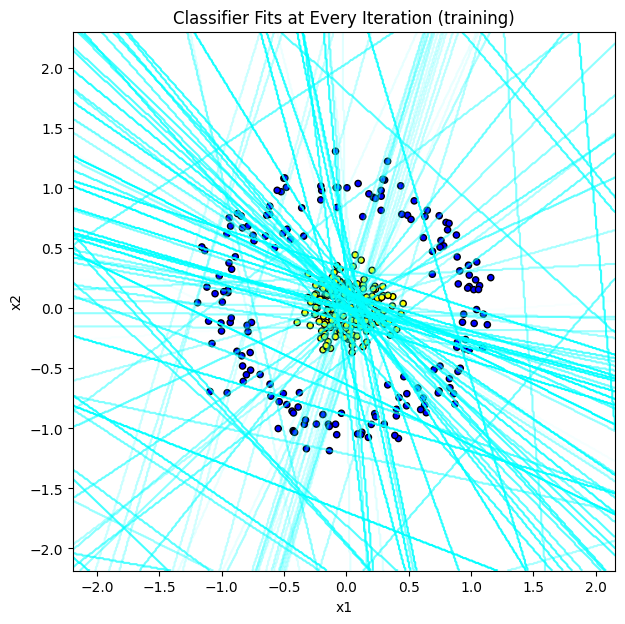

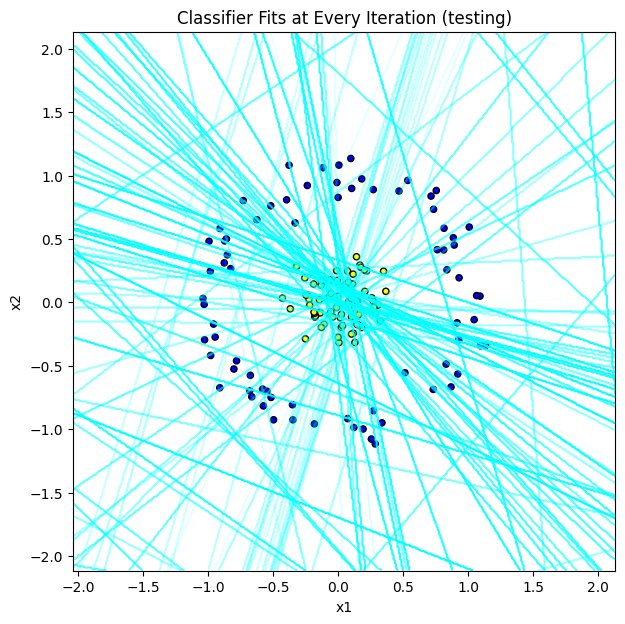

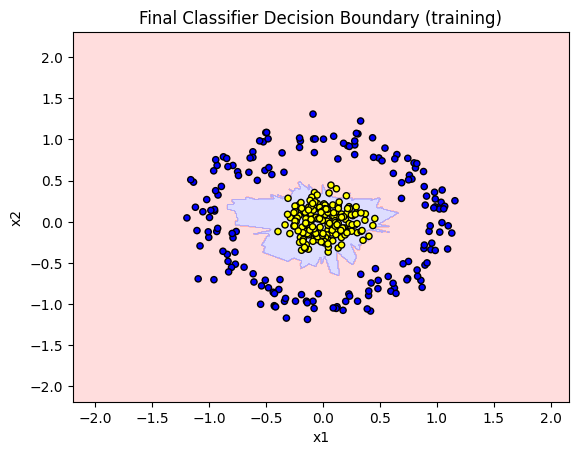

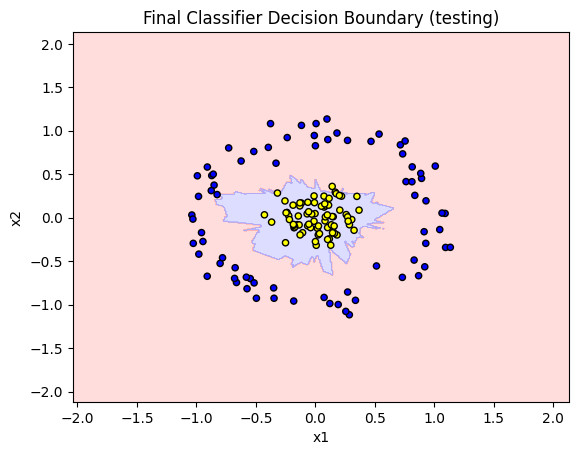

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()

# parameter grid for Logistic Regression
param_grid_logreg = {
    'base_clf__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'base_clf__solver': ['lbfgs', 'sag', 'saga'],  # Solver types
    'n_clf': [50, 100, 150],  # Number of weak classifiers in AdaBoost
    'eta': [0.5]  # Learning rate for AdaBoost
}

# Initialize AdaBoost with Logistic Regression as the base classifier
clf_logreg = AdaBoost(base_clf=logreg)

# Use GridSearchCV to tune hyperparameters
grid_search_logreg = GridSearchCV(estimator=clf_logreg, param_grid=param_grid_logreg, scoring='accuracy', cv=5)
grid_search_logreg.fit(X_train, y_train)

# Best parameters and accuracy
print("Logistic Regression - Best Parameters:", grid_search_logreg.best_params_)
print("Logistic Regression - Best Accuracy:", grid_search_logreg.best_score_)
# print("Logistic Regression - Best estimator:", grid_search_logreg.best_estimator_)
best_adaboost_logreg = grid_search_logreg.best_estimator_

# Evaluate on the test set
y_pred_logreg = grid_search_logreg.best_estimator_.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Test Accuracy (LogReg): {accuracy_logreg:.4f}")

# Plot classifier fits at every iteration
best_adaboost_logreg.plot_overlaid_iterations(X_train, y_train)
best_adaboost_logreg.plot_overlaid_iterations(X_test, y_test, dataset_type="testing")

# Plot final ensembled classifier decision boundary
best_adaboost_logreg.plot_final_classifier(X_train, y_train)
best_adaboost_logreg.plot_final_classifier(X_test, y_test, dataset_type="testing")

## 2. Decision Stump (Depth=1 Decision Tree)

We don't have any hyperparamteres to tune here. Simply tuning adaboost tuning


Decision Stump - Best Parameters: {'eta': 0.1, 'n_clf': 100}
Decision Stump - Best Accuracy: 0.9857142857142858
Test Accuracy (Decision Stump): 0.9933


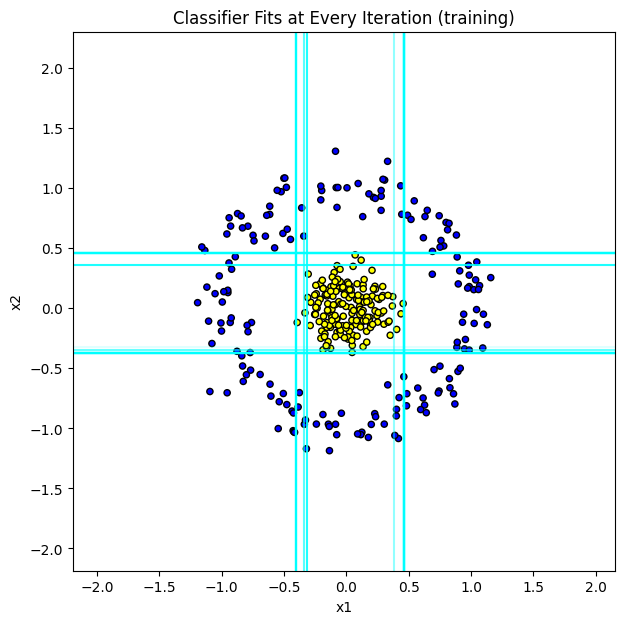

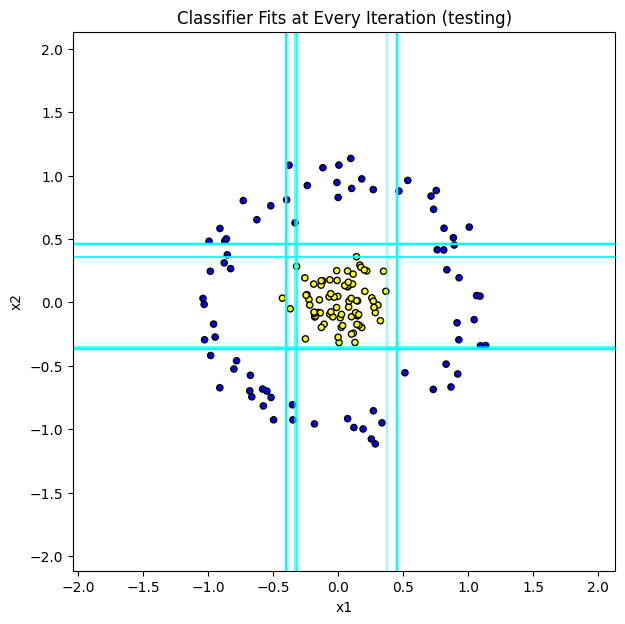

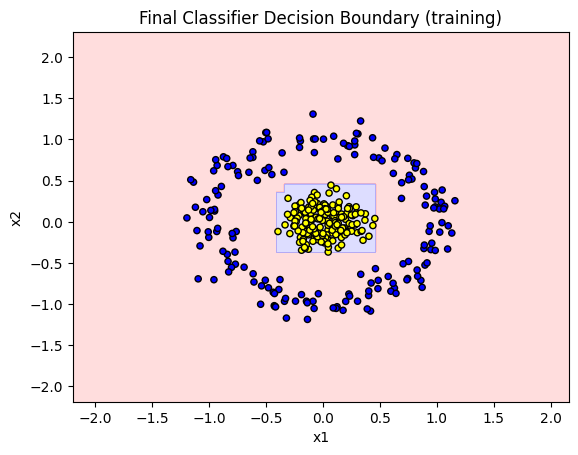

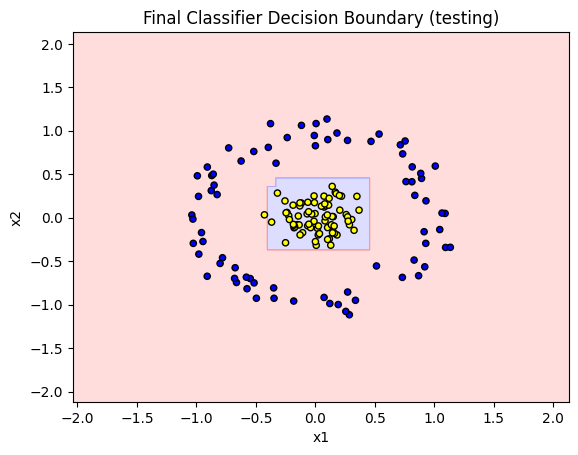

In [6]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Stump (Depth=1)
decision_stump = DecisionTreeClassifier(max_depth=1)

#parameter grid for AdaBoost
param_grid_stump = {
    'n_clf': [50, 100, 150],  # Number of weak classifiers
    'eta': [0.1, 0.5, 1.0]  # Learning rate for AdaBoost
}

# Initialize AdaBoost with Decision Stump as the base classifier
clf_stump = AdaBoost(base_clf=decision_stump)

# Use GridSearchCV to tune hyperparameters
grid_search_stump = GridSearchCV(estimator=clf_stump, param_grid=param_grid_stump, scoring='accuracy', cv=5)
grid_search_stump.fit(X_train, y_train)

# Best parameters and accuracy
print("Decision Stump - Best Parameters:", grid_search_stump.best_params_)
print("Decision Stump - Best Accuracy:", grid_search_stump.best_score_)

# Evaluate on the test set
y_pred_stump = grid_search_stump.best_estimator_.predict(X_test)
accuracy_stump = accuracy_score(y_test, y_pred_stump)
print(f"Test Accuracy (Decision Stump): {accuracy_stump:.4f}")

# Plot classifier fits at every iteration
grid_search_stump.best_estimator_.plot_overlaid_iterations(X_train, y_train)
grid_search_stump.best_estimator_.plot_overlaid_iterations(X_test, y_test, dataset_type="testing")

# Plot final ensembled classifier decision boundary
grid_search_stump.best_estimator_.plot_final_classifier(X_train, y_train)
grid_search_stump.best_estimator_.plot_final_classifier(X_test, y_test, dataset_type="testing")

## 3. Decision Tree (Depth=3)

Hyperparameters:

Tree Depth (max_depth): A deeper tree allows for more complex decision boundaries but increases the risk of overfitting.

Minimum Samples per Leaf (min_samples_leaf): Ensures a minimum number of samples per leaf node. A higher value reduces overfitting by preventing overly small, specific splits.

Maximum Number of Features (max_features): Limits the number of features used in each split, improving generalization and reducing overfitting.

Decision Tree - Best Parameters: {'base_clf__max_depth': 2, 'base_clf__min_samples_leaf': 1, 'eta': 0.5, 'n_clf': 100}
Decision Tree - Best Accuracy: 0.9885714285714287
Test Accuracy (Decision Tree): 0.9933


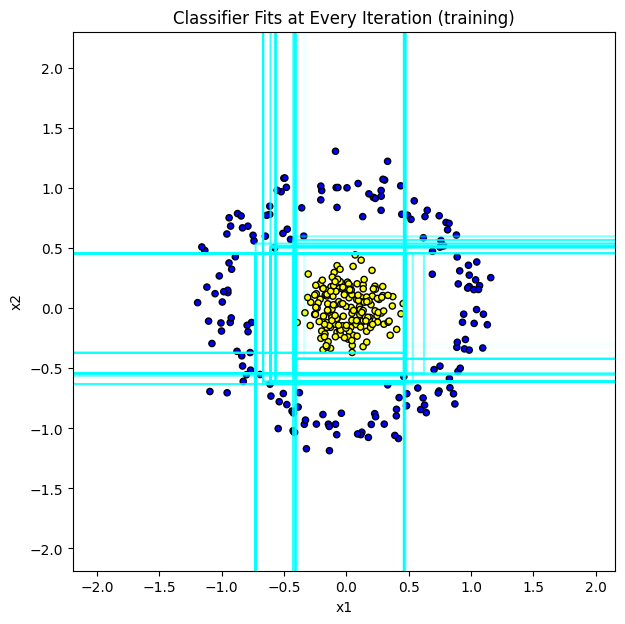

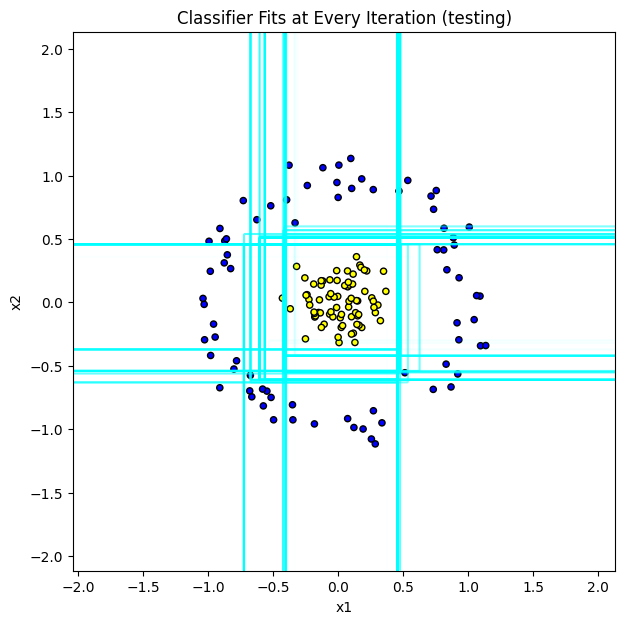

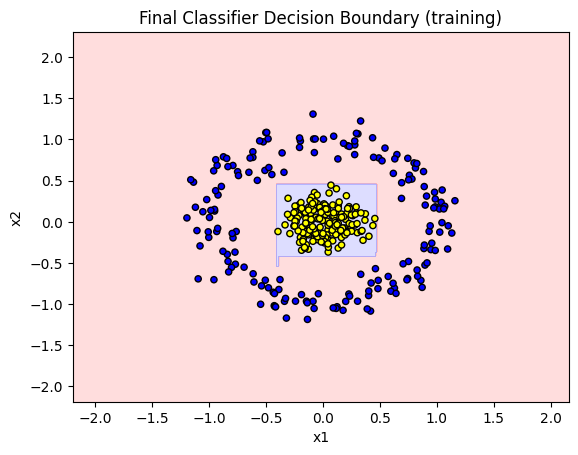

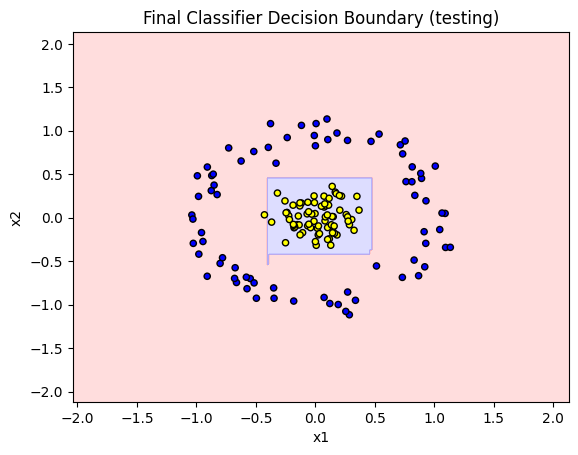

In [7]:
decision_tree = DecisionTreeClassifier(max_depth=3)

# parameter grid for Decision Tree
param_grid_tree = {
    'base_clf__max_depth': [2, 3, 4],  # Maximum depth of the tree
    'base_clf__min_samples_leaf': [1, 2, 5],  # Minimum samples per leaf
    'n_clf': [50, 100, 150],  # Number of weak classifiers in AdaBoost
    'eta': [0.1, 0.5, 1.0]  # Learning rate
}

# Initialize AdaBoost with Decision Tree as the base classifier
clf_tree = AdaBoost(base_clf=decision_tree)

# Use GridSearchCV to tune hyperparameters
grid_search_tree = GridSearchCV(estimator=clf_tree, param_grid=param_grid_tree, scoring='accuracy', cv=5)
grid_search_tree.fit(X_train, y_train)

# Best parameters and accuracy
print("Decision Tree - Best Parameters:", grid_search_tree.best_params_)
print("Decision Tree - Best Accuracy:", grid_search_tree.best_score_)

# Evaluate on the test set
y_pred_tree = grid_search_tree.best_estimator_.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Test Accuracy (Decision Tree): {accuracy_tree:.4f}")

# Plot classifier fits at every iteration (overlaid in one plot)
grid_search_tree.best_estimator_.plot_overlaid_iterations(X_train, y_train)
grid_search_tree.best_estimator_.plot_overlaid_iterations(X_test, y_test, dataset_type="testing")

# Plot final ensembled classifier decision boundary
grid_search_tree.best_estimator_.plot_final_classifier(X_train, y_train)
grid_search_tree.best_estimator_.plot_final_classifier(X_test, y_test, dataset_type="testing")

## 4. Linear SVM

Hyperaparameteres:

Regularization (C):: Like in logistic regression, C controls regularization strength. Higher values mean less regularization, leading to potentially overfitting the data.

Kernel:
Effect: The dataset being non-linear means a linear kernel may not be sufficient. Using a more expressive kernel (like RBF) can improve performance but is computationally heavier. I'll just stick to linear kernel here.


SVM - Best Parameters: {'base_clf__C': 0.01, 'eta': 0.1, 'n_clf': 50}
SVM - Best Accuracy: 0.45999999999999996
Test Accuracy (SVM): 0.6733


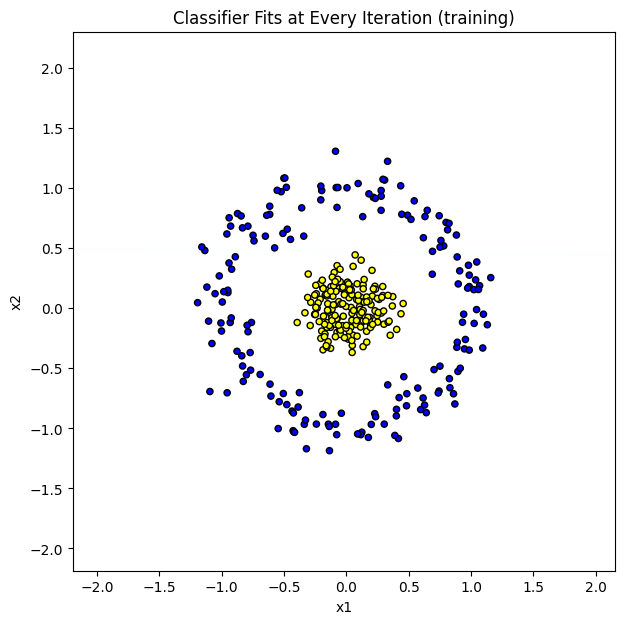

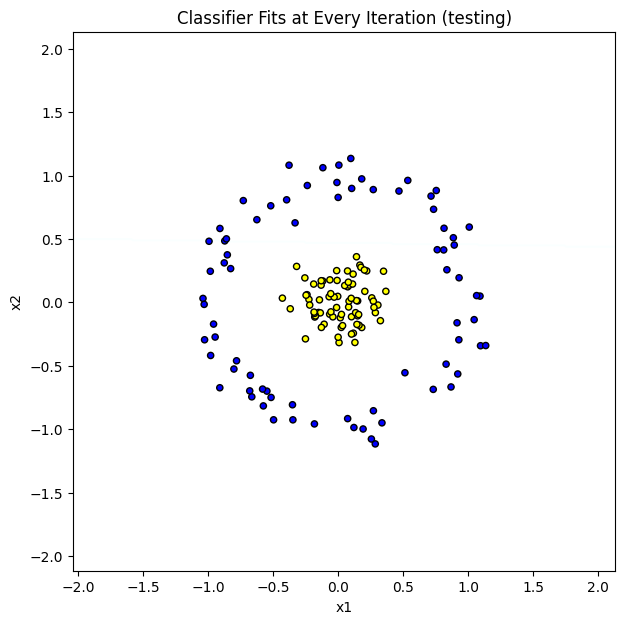

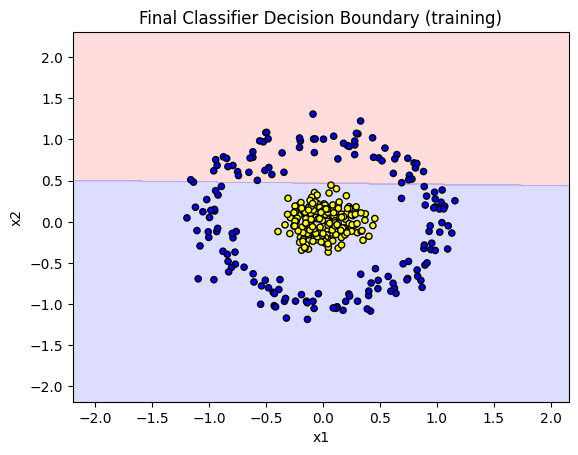

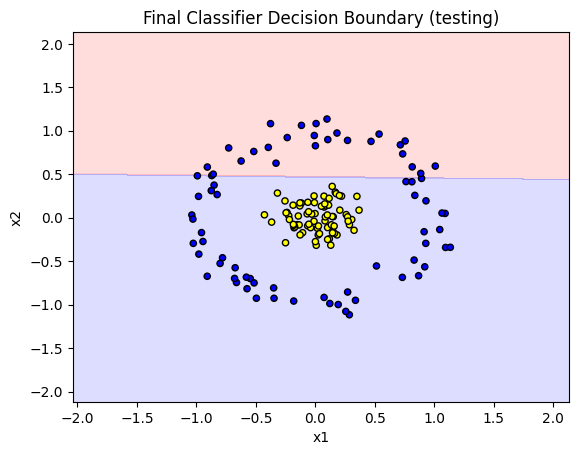

In [8]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')

# parameter grid for SVM
param_grid_svm = {
    'base_clf__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'n_clf': [50, 100, 150],  # Number of weak classifiers in AdaBoost
    'eta': [0.1, 0.5, 1.0]  # Learning rate for AdaBoost
}

# Initialize AdaBoost with SVM as the base classifier
clf_svm = AdaBoost(base_clf=svm)

# Use GridSearchCV to tune hyperparameters
grid_search_svm = GridSearchCV(estimator=clf_svm, param_grid=param_grid_svm, scoring='accuracy', cv=5)
grid_search_svm.fit(X_train, y_train)

# Best parameters and accuracy
print("SVM - Best Parameters:", grid_search_svm.best_params_)
print("SVM - Best Accuracy:", grid_search_svm.best_score_)

# Evaluate on the test set
y_pred_svm = grid_search_svm.best_estimator_.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (SVM): {accuracy_svm:.4f}")

# Plot classifier fits at every iteration (overlaid in one plot)
grid_search_svm.best_estimator_.plot_overlaid_iterations(X_train, y_train)
grid_search_svm.best_estimator_.plot_overlaid_iterations(X_test, y_test, dataset_type="testing")

# Plot final ensembled classifier decision boundary
grid_search_svm.best_estimator_.plot_final_classifier(X_train, y_train)
grid_search_svm.best_estimator_.plot_final_classifier(X_test, y_test, dataset_type="testing")

## 5. Linear Discriminant Analysis (LDA)

Hyperparamters:

Solver (solver): Different solvers handle certain datasets better. For example, 'svd' works with large datasets, while 'lsqr' or 'eigen' handles regularization.



LDA - Best Parameters: {'base_clf__solver': 'svd', 'eta': 0.5, 'n_clf': 50}
LDA - Best Accuracy: 0.5657142857142857
Test Accuracy (LDA): 0.4933


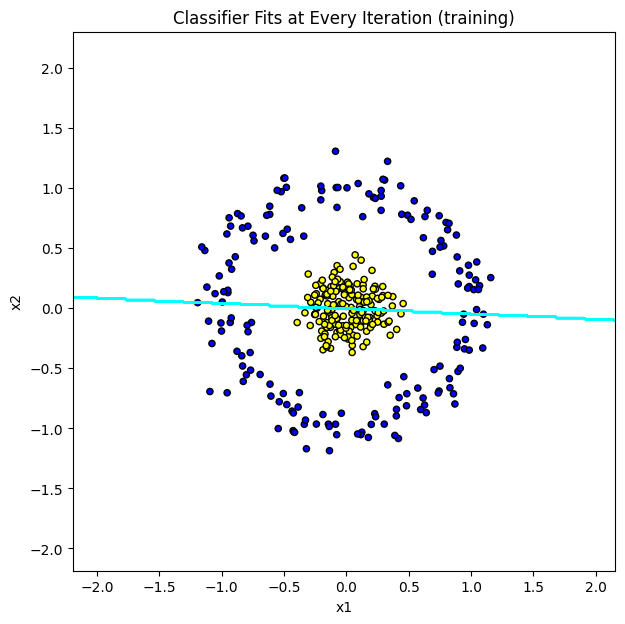

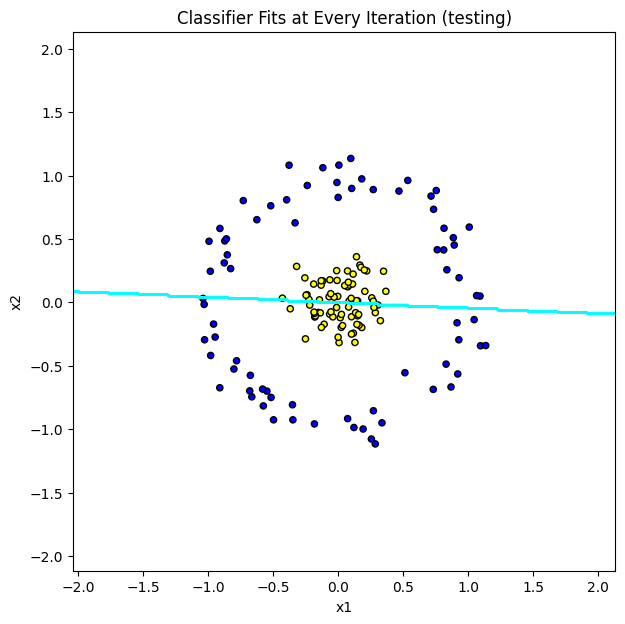

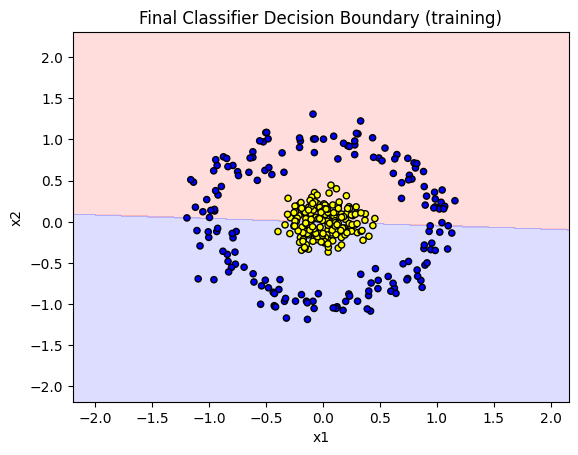

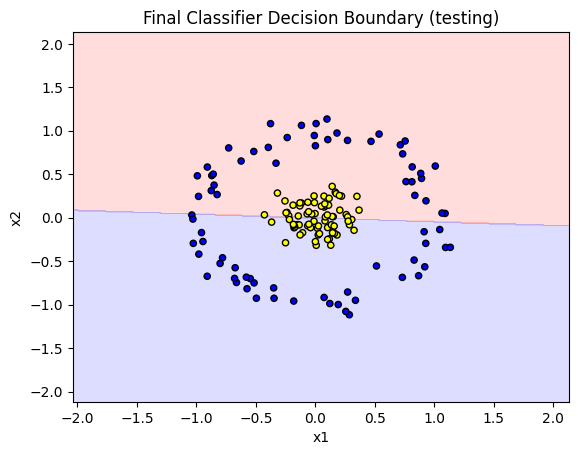

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

# parameter grid for LDA
param_grid_lda = {
    'base_clf__solver': ['svd', 'lsqr', 'eigen'],  # Solver types
    'n_clf': [50, 100, 150],  # Number of weak classifiers in AdaBoost
    'eta': [0.5]  # Learning rate for AdaBoost
}

# Initialize AdaBoost with LDA as the base classifier
clf_lda = AdaBoost(base_clf=lda)

# Use GridSearchCV to tune hyperparameters
grid_search_lda = GridSearchCV(estimator=clf_lda, param_grid=param_grid_lda, scoring='accuracy', cv=5)
grid_search_lda.fit(X_train, y_train)

# Best parameters and accuracy
print("LDA - Best Parameters:", grid_search_lda.best_params_)
print("LDA - Best Accuracy:", grid_search_lda.best_score_)

# Evaluate on the test set
y_pred_lda = grid_search_lda.best_estimator_.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print(f"Test Accuracy (LDA): {accuracy_lda:.4f}")

# Plot classifier fits at every iteration (overlaid in one plot)
grid_search_lda.best_estimator_.plot_overlaid_iterations(X_train, y_train)
grid_search_lda.best_estimator_.plot_overlaid_iterations(X_test, y_test, dataset_type="testing")

# Plot final ensembled classifier decision boundary
grid_search_lda.best_estimator_.plot_final_classifier(X_train, y_train)
grid_search_lda.best_estimator_.plot_final_classifier(X_test, y_test, dataset_type="testing")

# References    

1. Numpy docs
2. Matplotlib docs
3. Scikit-learn
4. GeeksForGeeks
5. stackoverflow
6. GPT